# Ejemplo simplificación
Con este ejemplo se pretende explicar cuál es el proceso para aproximar una función utilizando una KAN. Este ejemplo parte bajo la premisa de que desconocemos cuál es la estructura de la KAN óptima para representar dicha función. Por esto, primero construiremos una KAN suficientemente grande y la entrenaremos utilizando un regularizador que favorezca la dispersión. Una vez se han identificado aquellas funciones de activación que no son relevantes en la representación de la función objetivo se eliminan de la red, este proceso se conoce como poda. De esta manera, conseguiremos una versión más sencilla de la red original. La ventaja de una red más sencilla es que es más interpretable.

La función que vamos a tratar de aproximar es $f(x, y, z)=e^{\sin(2 \pi x) + 2y + 1.5z^2}$.

El primer paso será entrenar el modelo utilizando regularización.

In [36]:
from kan import *

# Permite utilizar CPU o GPU según las características del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definimos la estructura de la KAN
model = KAN(width=[3,5,1], grid=3, k=3, seed=1, device=device)

# Definimos la función que queremos aproximar y generamos el conjunto de datos en consecuencia
f = lambda x: torch.exp(torch.sin(2 * torch.pi * x[:,0]) + 2 * x[:,1] + 1.5*x[:,2]**2)
dataset = create_dataset(f, n_var=3, device=device, seed=1)

checkpoint directory created: ./model
saving model version 0.0


In [37]:
# Entrenamos el modelo utilizando el optimizador LBFGS utilizando regularización
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.05);

| train_loss: 4.59e-01 | test_loss: 6.48e-01 | reg: 1.73e+01 | : 100%|█| 50/50 [00:13<00:00,  3.71it

saving model version 0.1


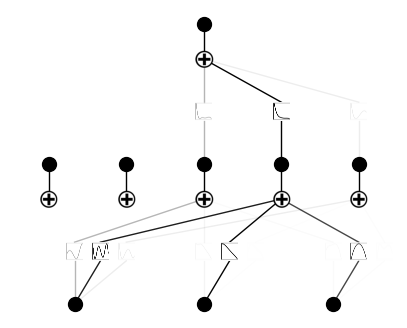

In [38]:
# Mostramos la forma que tiene la KAN
model.plot()

Como se puede ver hay muchas aristas y vértices del grafo que no aportan apenas información en la predicción. Por ello, realizamos la poda de estas y nos quedamos con las funciones de activación más relevantes.

saving model version 0.2


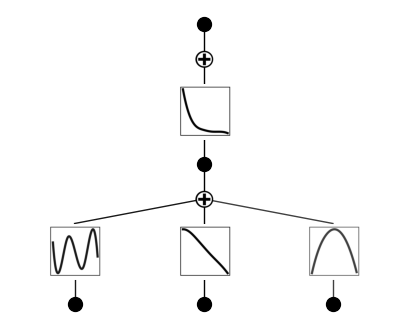

In [39]:
# Hacemos la poda del modelo anterior
pruned_model = model.prune(node_th=2e-1, edge_th=2e-1)
pruned_model.plot()

In [73]:
# Volvemos a entrenar el modelo
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 6.13e-01 | test_loss: 7.70e-01 | reg: 1.24e+01 | : 100%|█| 100/100 [00:17<00:00,  5.86

saving model version 1.3


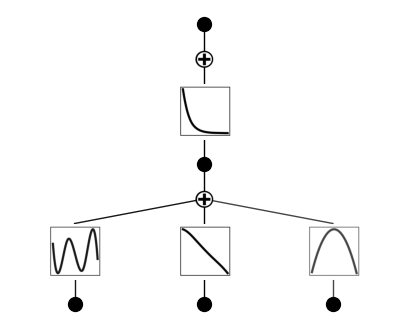

In [74]:
pruned_model.plot()

Como se puede ver esta nueva red es mucho más sencilla y, por tanto, más interpretable. La idea ahora es tratar de convertir las funciones de activación en expresiones simbólicas ($\cos, \log, \dots$). Para ello utilizamos las funciones que proporciona la librería y nos fijamos en el grafo, para tomar decisiones.

In [75]:
pruned_model.suggest_symbolic(0,0,0);

  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        0    0.000000  0.000014           0                0    0.000003
1        x    0.198057 -0.318410           1                1    0.736318
2      cos    0.949162 -4.297659           2                2    0.740468
3      sin    0.949162 -4.297659           2                2    0.740468
4      exp    0.236438 -0.389164           2                2    1.522167


La función de activación $(0,0,0)$ se puede ajustar con un $\sin$ o un $\cos$. Nótese que es lógico que ambas tengan las mismas puntuaciones ya que
$$
\sin(x) = \cos(x-\frac{\pi}{2}).
$$

In [76]:
# Ajustamos la función de activación (0,0,0) a sin
pruned_model.fix_symbolic(0,0,0,'sin');

r2 is 0.9491617679595947
saving model version 1.4


In [77]:
pruned_model.suggest_symbolic(0,1,0);

  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        x    0.998941  -9.869528           1                1   -1.173906
1      cos    0.999324 -10.509178           2                2   -0.501836
2      sin    0.999324 -10.509178           2                2   -0.501836
3      x^2    0.998973  -9.913385           2                2   -0.382677
4      exp    0.998972  -9.912307           2                2   -0.382461


En este caso, hay varias funciones con la misma puntuación $r2$. Eligimos $x$ porque es la función más similar al de la gráfica del grafo.

In [78]:
pruned_model.fix_symbolic(0,1,0,'x');

r2 is 0.9989410042762756
saving model version 1.5


In [79]:
pruned_model.suggest_symbolic(0,2,0);

   function  fitting r2    r2 loss  complexity  complexity loss  total loss
0       x^2    0.999990 -15.643450           2                2   -1.528690
1       cos    0.999695 -11.633467           2                2   -0.726693
2  gaussian    0.999958 -14.232193           3                3   -0.446439
3       sin    0.998788  -9.676398           2                2   -0.335280
4         0    0.000000   0.000014           0                0    0.000003


La fórmula con mayor puntuación es $x^3$. Además, es coherente con la función del grafo. Elegimos esta opción.

In [80]:
pruned_model.fix_symbolic(0,2,0,'x^2');

r2 is 0.9999904632568359
saving model version 1.6


In [81]:
pruned_model.suggest_symbolic(1,0,0);

   function  fitting r2    r2 loss  complexity  complexity loss  total loss
0       exp    0.999831 -12.444561           2                2   -0.888912
1         0    0.000000   0.000014           0                0    0.000003
2      tanh    0.999193 -10.258030           3                3    0.348394
3     1/x^2    0.986690  -6.230312           2                2    0.353938
4  gaussian    0.999041 -10.010981           3                3    0.397804


Existen varias fórmulas con buenas puntuaciones. Elegimos $exp$ por ser la que mejor se ajusta al gráfico.

In [82]:
pruned_model.fix_symbolic(1,0,0,'exp');

r2 is 0.9998306035995483
saving model version 1.7


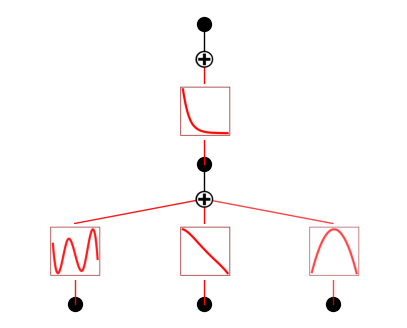

In [83]:
pruned_model.plot()

Una vez hemos ajustado todas las fórmulas, volvemos a entrenar el modelo.

In [84]:
# Volvemos a entrenar el modelo
pruned_model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 50/50 [00:14<00:00,  3.35it/s]

saving model version 1.8


Como podemos ver el entrenamiento ha fallado. La función de pérdida devuelve $nan$. Esto es síntoma de que se ha producido un overflow o un underflow. Veamos como solucionarlo.

En primer lugar, recuperamos el modelo que teníamos y volvemos a entrenarlo.

In [85]:
pruned_model = KAN.loadckpt('./model/' + '0.2')
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 6.13e-01 | test_loss: 7.70e-01 | reg: 1.24e+01 | : 100%|█| 100/100 [00:17<00:00,  5.76

saving model version 1.3


A continuación, vamos ajustar las funciones de activación de la primera capa, pero no de la segunda. Después, vamos a volver a entrenar el modelo. La idea detrás de esto es que permitimos al modelo ajustar correctamente las funciones simbólicas de la primera capa, pero sin cambiar la segunda. Una vez se ah realizado este entrenamiento, ya podemos fijar las funciones de la segunda capa y volver a entrenar.

r2 is 0.9491617679595947
saving model version 1.4
r2 is 0.9989410042762756
saving model version 1.5
r2 is 0.9999904632568359
saving model version 1.6


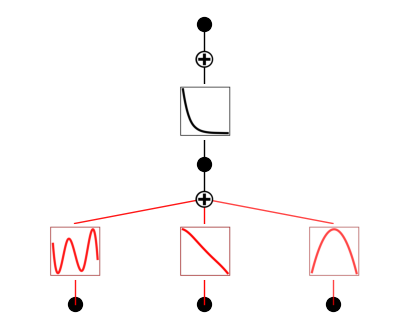

In [86]:
# Volvemos a fijar las funciones
pruned_model.fix_symbolic(0,0,0,'sin');
pruned_model.fix_symbolic(0,1,0,'x');
pruned_model.fix_symbolic(0,2,0,'x^2');
pruned_model.plot()

In [87]:
# Reentrenamos el modelo
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 2.68e-02 | test_loss: 2.96e-02 | reg: 2.77e+00 | : 100%|█| 100/100 [00:25<00:00,  3.86


saving model version 1.7


In [88]:
# Fijamos la función exponencial y hacemos el último entrenamiento
pruned_model.fix_symbolic(1,0,0,'exp');
pruned_model.fit(dataset, opt="LBFGS", steps=100);

r2 is 0.9999825954437256
saving model version 1.8


| train_loss: 6.20e-06 | test_loss: 6.15e-06 | reg: 0.00e+00 | : 100%|█| 100/100 [00:10<00:00,  9.84


saving model version 1.9


Nótese como este último entrenamiento ha obtenido la pérdida más baja con diferencia. Esto es una muestra de que hemos conseguido un ajuste muy fino de la función deseada. Recuperemos la fórmula.

In [89]:
# Obtenemos la fórmula final
formula = pruned_model.symbolic_formula()[0][0]
formula = ex_round(formula, 4)
display(formula)

1.0*exp(2.0*x_2 + 1.5*x_3**2 - 1.0*sin(6.2832*x_1 + 9.4248))

Nótese como esta fórmula es equivalente a nuestra fórmula buscada (el $\sin$ se encuentra multiplicada por $-1$, pero $-\sin(x) = sin(x + 3\pi)$).

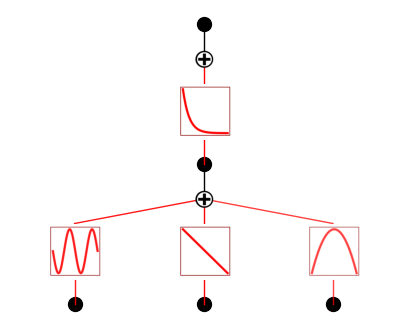

In [90]:
pruned_model.plot()